<a href="https://colab.research.google.com/github/LittleAri/ALICE/blob/main/Mask_RCNN_Basic_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask RCNN Tests

Testing [Mask RCNN](https://github.com/matterport/Mask_RCNN) based on this [blog](https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/) post. 

Using pre-trained weights to segment labels from a sample of ALICE images. 


To run this notebook, download the files in the folder Mask_RCNN_Files in the ALICE repository.

#### Installing Packages
Install certain versions of packages.

In [1]:
!pip install tensorflow==1.15.5
!pip install keras==2.3.1
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install numpy==1.21.5

     |████████████████████████████████| 110.5 MB 1.0 kB/s 
     |████████████████████████████████| 3.8 MB 48.2 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 503 kB 46.3 MB/s 
     |████████████████████████████████| 2.9 MB 37.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=21f2bd1290bc19ef6f13a1767874fe8f32bc72e57c17392561c673104ab62cfc
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tens

     |████████████████████████████████| 377 kB 8.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ms69a5z0
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ms69a5z0
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=bb6721c5676aeca87527ba2b063c3495af289e15a357239ee6d0cc27ec4ab480
  Stored in directory: /tmp/pip-ephem-wheel-cache-sytj7cbf/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib
     |████████████████████████████████| 15.7 MB 7.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take i

#### Imports

In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files
import tqdm
from copy import deepcopy
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
import warnings
warnings.filterwarnings("ignore")
import config
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import utils
import model as modellib
import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

Using TensorFlow backend.


#### Weights

In [4]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use `tf.cast` instead.


#### Prediction Test

In [7]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [26]:
file = '013612433_additional_2.JPG'
image = skimage.io.imread("Images/"+file)

Processing 1 images
image                    shape: (4000, 6000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 6000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


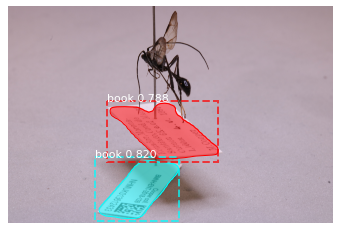

In [27]:
fig,ax = plt.subplots()
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

# Note: Ari updated display_instances to include an ax variable.
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'],ax=ax)

In [34]:
_,_,total_objects = np.shape(r['masks'])
for i in range(0,total_objects):
  nm = file[:-4]+"_"+str(i)+'.npy'
  np.save(nm,r['masks'][:,:,i])
  files.download(nm) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Automated Tests

Test the automated process from a folder of images, "Images". Save the plot of the image with the highlighted objects, and save (and automatically download) the individual masks as numpy files.

In [8]:
names = []

for file in os.listdir("Images"):
  names.append(file)

In [9]:
for file in tqdm.tqdm(names):
  # Load image:
  try:
    image = skimage.io.imread("Images/"+file)
    print("Successfully loaded image: "+file)
    # CNN segmentation:
    results = model.detect([image], verbose=1)
    r = results[0]
    # Save plot:
    fig,ax = plt.subplots()
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'],ax=ax)
    fig.savefig(file,margin=0.01)
    files.download(file) 
    plt.close()
    print("Successfully downloaded plot for image: "+file)
    # Download individual masks:
    _,_,total_objects = np.shape(r['masks'])
    for i in range(0,total_objects):
      nm = file[:-4]+"_"+str(i)+'.npy'
      np.save(nm,r['masks'][:,:,i])
      files.download(nm) 
    print("Successfully downloaded masks for image: "+file)
  except:
    print("Error with image: "+file)

  0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded image: Sarc043_additional_3.JPG
Processing 1 images
image                    shape: (4000, 6000, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 6000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully downloaded plot for image: Sarc043_additional_3.JPG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 17%|█▋        | 1/6 [00:19<01:35, 19.14s/it]

Successfully downloaded masks for image: Sarc043_additional_3.JPG
Successfully loaded image: 013612445_additional_4.JPG
Processing 1 images
image                    shape: (4000, 6000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 6000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully downloaded plot for image: 013612445_additional_4.JPG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 33%|███▎      | 2/6 [00:36<01:12, 18.15s/it]

Successfully downloaded masks for image: 013612445_additional_4.JPG
Error with image: .ipynb_checkpoints
Successfully loaded image: Drag005_additional_4.jpg
Processing 1 images
image                    shape: (5792, 8688, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 8688.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully downloaded plot for image: Drag005_additional_4.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 67%|██████▋   | 4/6 [01:04<00:30, 15.44s/it]

Successfully downloaded masks for image: Drag005_additional_4.jpg
Successfully loaded image: Aso231006_additional_4.JPG
Processing 1 images
image                    shape: (4000, 6000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 6000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully downloaded plot for image: Aso231006_additional_4.JPG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 83%|████████▎ | 5/6 [01:21<00:15, 15.97s/it]

Successfully downloaded masks for image: Aso231006_additional_4.JPG
Successfully loaded image: 013612433_additional_2.JPG
Processing 1 images
image                    shape: (4000, 6000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 6000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully downloaded plot for image: 013612433_additional_2.JPG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 6/6 [01:41<00:00, 16.88s/it]

Successfully downloaded masks for image: 013612433_additional_2.JPG
